In [901]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib as mpl

sns.set_style()
np.random.seed(42)

# Обучение без учителя (unsupervised learning) и разведочный анализ данных (exploratory data analysis)

При решении стандартных задач на построение регрессионной или классифицирующих моделей бывает полезно предварительно поисследовать данные: поискать в них внутреннюю структуру, выделить главные и лишние признаки, обнаружить выбросы. 

Для этих целей используются различные способы визуализации, кластеризация и статистические тесты.

Не сложно догадаться, что в методах обучения без учителя не требуется целевая переменная. Эти методы используются для того, чтобы извлечь какую-то информацию из самих данных. Часто в качестве подготовительного шага перед решением каких-то других задач.

## Снижение размерности

Большое количество признаков в датасете может приводить к проблемам.

1) Вычислительная сложность. Это легко заметить, если попробовать работать в области NLP. При создании bag of words модели языка имеют огромную размерность и обрабатываются ооочень долго.

2) Переобучение. Для многих ML-алгоритмов большое количество признаков приводит к тому, что они идеально запоминают тренировочный датасет и не делают никакого обобщения. Для некоторых алгоритмов от числа признаков зависит сложность модели и переобучение происходит из-за этого. Но даже, если это не так, признаки могут содержать шум, и модель запомнит тренировочный шум, а не необходимое распределение.

3) Чем больше признаков, тем сложнее визуализация и вообще любая попытка понять датасет собственной нейросетью.

### Метод главных компонент (Principal component analysis )

http://setosa.io/ev/principal-component-analysis/

https://www.youtube.com/watch?v=_UVHneBUBW0

In [902]:
import sklearn.datasets
from sklearn.decomposition import PCA
np.set_printoptions(2, suppress=True)

Пусть наши данные описываются $m$ признаками. Это значит, что они лежат в $m$-мерном признаковом пространстве, признаки - координатные оси пространства (базисные векторы). PCA линейно отображает данные в новую ортогональную систему координат, такую что разброс данных по первой оси координат максимально, по второй максимально возможное после выбора первой и так далее. Эти новые оси называются главными компонентами.

Само по себе такое отображение не снижает размерности и сохраняет всю информацию. Однако, если данные на самом деле лежат в пространстве меньшей размерности, чем $m$, то после трансформации мы сможем отбросить лишние оси, сохранив все самое важное.

#### Пример 1

Первый пример на двумерном датасете, на нем видно, что происходит с данными при PCA отображении.

Covariance is:
[[3540.   1718.84]
 [1718.84 1475.15]]


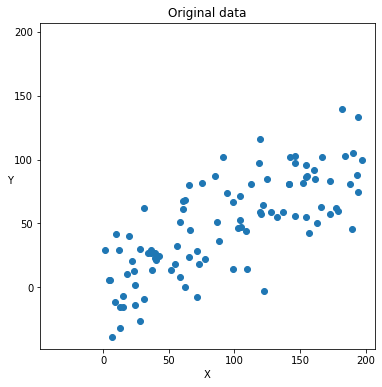

In [903]:
x = np.random.uniform(0, 200, 100)
np.random.seed(0)
noise = np.random.randn(len(x)) * 25
y = 0.5 * x + noise
X = np.vstack([x,y]).T
plt.figure(figsize=(6,6));
plt.scatter(*X.T);
lims = (np.min([*plt.ylim(), *plt.xlim()]),
        np.max([*plt.ylim(), *plt.xlim()]))
plt.xlim(lims);
plt.ylim(lims);
plt.xlabel('X')
plt.ylabel('Y', rotation='horizontal')
plt.title('Original data');
print('Covariance is:');
print(np.cov((X-X.mean()).T));

In [904]:
X_centered = X - X.mean(axis=0)
pca = PCA(random_state=42)
X_pca = pca.fit_transform(X);

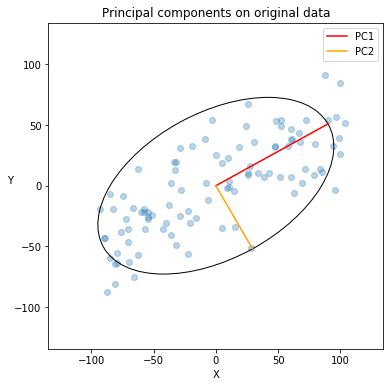

In [913]:
fig, axs = plt.subplots(1, figsize=(6,6))
plt.scatter(*X_centered.T, alpha=0.3)
max_ = np.abs(X_centered).max()
components = []
colors=['red', 'orange']
for i in range(len(pca.components_)):
    vector =  4 * np.sqrt(pca.singular_values_[i]) * np.vstack([pca.components_[i], [0, 0]])
    components.append(vector)
    max_ = np.max([max_, np.abs(vector).max()])
    plt.plot(*vector.T, color=colors[i], label=F'PC{i+1}')
max_ *= 1.3
lims = [-max_, max_]
plt.legend()
angle = np.degrees(np.arccos(np.dot(pca.components_[0], [1,0])))

ellipse = mpl.patches.Ellipse(
    xy=(0, 0),
    width=2*4*np.sqrt(pca.singular_values_[0]),
    height=2*4*np.sqrt(pca.singular_values_[1]),
    angle=angle,
    fill=False
)
axs.add_patch(ellipse);
plt.title('Principal components on original data')
plt.xlim(lims);
plt.ylim(lims);
plt.xlabel('X');
plt.ylabel('Y', rotation='horizontal');

Covariance is:
[[4512.65    0.  ]
 [   0.    502.5 ]]


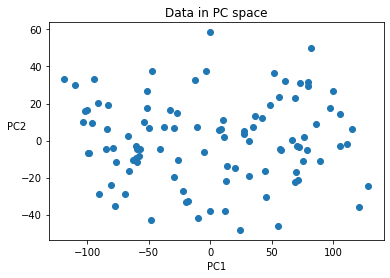

In [914]:
plt.scatter(*X_pca.T);
plt.xlabel('PC1');
plt.ylabel('PC2', rotation='horizontal');
plt.title('Data in PC space');
print('Covariance is:')
print(np.cov(X_pca.T));

In [915]:
print('Original variance sum:', np.diag(np.cov(X.T)).sum())
print('PC variance sum', np.cov(X_pca.T).sum())

Original variance sum: 5015.144898594348
PC variance sum 5015.14489859435


Мы видим, что в новом базисе данные нескореллированы (значения в матрице ковариаций вне диагонали). Разброс сконцентрировался на первой оси. Также сумма новых разбросов равна сумме разбросов в исходном базисе (если брать значения только на диагонали). Вся изменчивость данных сохранена

#### Пример 2

Разберем другой пример, где будет видно, как может уменьшиться размерность

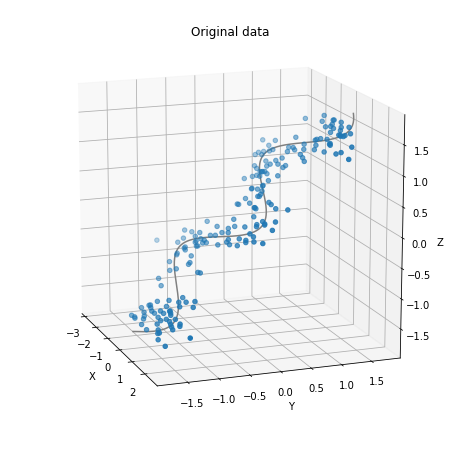

In [979]:
from mpl_toolkits.mplot3d import Axes3D

zline = np.linspace(0,15,1000)
yline = zline
xline = np.sin(zline)

zdata = 15*np.random.random(200)
ydata = zdata + 0.15 * np.random.randn(len(zdata))
xdata = np.sin(zdata) + 0.8 * np.random.randn(len(zdata))

X = np.vstack([xdata, ydata, zdata]).T
lines = np.vstack([xline, yline, zline]).T
X = (X - X.mean(axis=0)) / X.std(axis=0)
lines = (lines - lines.mean(axis=0)) / lines.std(axis=0)

fig = plt.figure(figsize=(8,8))
ax = plt.subplot(1,1,1, projection='3d')
ax.scatter3D(*X.T)
ax.plot3D(*lines.T, 'gray');
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(15,-20)
ax.set_title('Original data');

Данные на самом деле лежат на плоскости

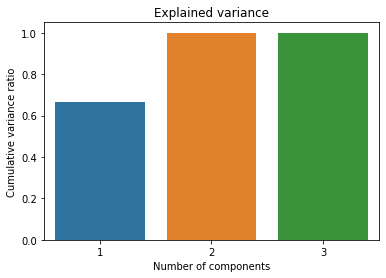

In [980]:
pca = PCA(random_state=42)
X_pca = pca.fit_transform(X)
sns.barplot([1,2,3], np.cumsum(pca.explained_variance_ratio_))
# plt.barplot(np.arange(1,4), np.cumsum(pca.explained_variance_ratio_), 'gray')
# plt.scatter(np.arange(1,4), np.cumsum(pca.explained_variance_ratio_))
# plt.xticks([1,2,3]);
plt.title('Explained variance');
plt.ylabel('Cumulative variance ratio')
plt.xlabel('Number of components');

Результаты PCA это подтверждают

In [937]:
lines_pca = pca.transform(lines)

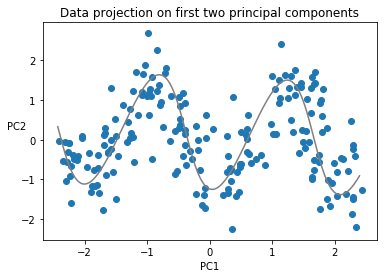

In [938]:
plt.scatter(*X_pca[:,:2].T);
plt.plot(lines_pca[:,0], lines_pca[:,1], 'gray');
plt.xlabel('PC1');
plt.ylabel('PC2', rotation='horizontal');
plt.title('Data projection on first two principal components');

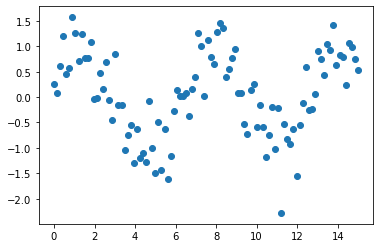

In [956]:
np.random.seed(42)
x = np.linspace(0,15,100)
y = np.sin(x) + np.random.randn(len(x)) * 0.5
z = np.random.randn(len(x)) * 200
plt.scatter(x, y)
pca = PCA(random_state=42)
t = pca.fit_transform(np.vstack([x,y,z]).T);

In [957]:
pca.explained_variance_ratio_

array([1., 0., 0.])

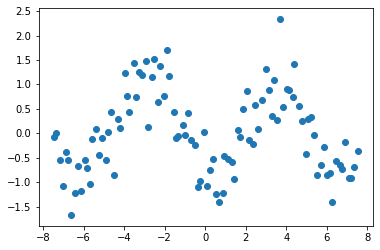

In [960]:
plt.scatter(t.T[1], t.T[2])

#### Как пользоваться методом

0) Также как и при нормализации все преобразования учатся на train'е, а к тесту применяются уже готовые, чтобы избежать переобучения.

1) Данные должны быть центрированы (в sklearn это происходит автоматически)

2) Если признаки имеют разный физический смысл или отличаются размерности (метры и сантиметры), то данные надо стандартизировать. И наоборот, если размерность одна и та же, при стандартизации мы потеряем информацию, поэтому ее не надо применять.

3) Находим PCA трансформацию

4) Оцениваем вклад главных компонент: график накопленной вариации по компонентам. Чем меньше данные скоррелированны, тем более пологим получается график, и тем менее эффективно будет уменьшение размерности. Выбираем удовлетворительную точность, отсекаем лишние компоненты. Более удобным часто является так называемый 'scree plot'
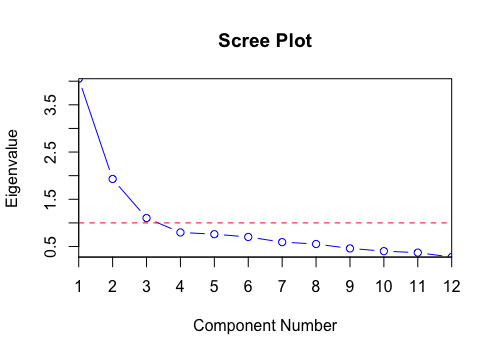

#### Математика PCA

Разберемся, как это преобразование получается.
Пусть $X$ - центрированная матрица данных. Мы хотим найти такое отображение $W$ таким образом, чтобы каждая компонента максимизировала разброс. Матрицу ковариации $Cov(X,X)=X^TX$ будем обозначать $Q$. При этом $W$ - ортогональная матрица (векторы - ортонормальные). Условие для первой компоненты:
$$w_{1}=\text{argmax}_{w}\{||Xw||^2\}=\text{argmax}_{w}\{w^TX^TXw\}=\text{argmax}_{w}\{w^TQ w\}$$
$$w_{1}^Tw_{1}=1$$
Составим функцию Лагранжа
$$L(x,\lambda)=w^TQ w-\lambda (w^Tw-1)$$
Продифференцируем и приравняем нулю
$$\frac{\partial L}{\partial w}=2Q w-2\lambda w=0$$
$$Q w=\lambda w$$
Если решение уравнения существует, то $w$ - собственный вектор. $Q$ - симметричная неотрицательная матрица, а значит у нее неотрицательные собственные значения, и собственные векторы могут быть ортогонализованы.
Отсюда получается, что $w_{1}$ - собственный вектор, соответствующий наибольшему собственному значению матрицы ковариаций.

$w_{2}$ находится аналогично, только надо добавить еще ограничение на ортогональность
$$w_{1}^Tw_{2}=0$$
Это слагаемое в новой функции Лагранжа занулится при оптимизации.
В итоге мы получаем

$$Q W=W \Lambda $$
И задача оптимизации отображения сводится к нахождению спектрального разложения матрицы ковариации данных

Современные библиотеки используют другую реализация PCA. Для любой матрицы существует сингулярное разложение (SVD):
$$X=U\Sigma W^T$$
$U$ - ортогональная матрица $(n,n)$, $W$ - ортогональная матрица $(p,p)$, а $\Sigma$ - $(n,p)$ прямоугольная диагональная матрица сингулярных чисел.
Тогда
$$Q=X^TX = W \Sigma^T U^T U \Sigma W^T=W \Sigma^T \Sigma W^T=W\hat{\Sigma}^2W^T$$
$\hat{\Sigma}$ - квадратная диагональная матрица сингулярных чисел из $\Sigma$
Отсюда
$$QW=W\hat{\Sigma}^2$$
Таким образом сингулярные числа матрицы данных - это корни собственных чисел матрицы ковариации, а правые сингулярные векторы матрицы данных - собственные векторы матрицы ковариации.


Такой вывод предпочтительнее, потому что считать спектральное разложение сложно, а для сингулярного разложения существуют эффективные численные методы

### tSNE

PCA применим всегда, но не всегда эффективен. Уменьшение размерности с помощью PCA - это нахождения эллипса или гиперкуба меньшей размерности, чем количество признаков. Однако данные могут иметь более сложную структуру, они могут лежать в нелинейных подпространствах (они называются многообразиями) и для приближения этих подпространств требуются другие методы.
Существует множество модификаций PCA, в том числе нелинейных, но мы рассмотрим совершенно другой алгоритм.

tSNE или стохастическое вложение соседей с t-распределением (невозможное название) - это очень популярный метод нелинейного снижения размерности для визуализации. Он хорошо показал себя на классических датасетах.

In [1242]:
from sklearn.manifold import TSNE

In [1243]:
digits = sklearn.datasets.load_digits()
pca_digits = PCA(n_components=2, random_state=42).fit_transform(digits['data'])
tsne_digits = TSNE(
    perplexity=15, random_state=42).fit_transform(
    digits['data'])

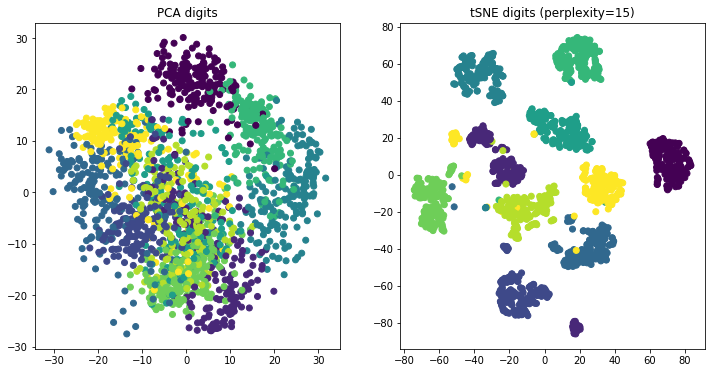

In [1244]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(*pca_digits.T, c=digits['target']);
plt.title('PCA digits')
plt.subplot(1,2,2)

plt.scatter(*tsne_digits.T, c=digits['target'])
plt.title(F'tSNE digits (perplexity={15})');

В пространстве, полученном tSNE, цифры очень хорошо разделяются. При этом даже не пришлось перебирать параметры.

Не будем вдаваться в подробности того, как tSNE устроен математически. Укажем только на характерные особенности

1) tSNE - метрический метод. Он измеряет расстояния между объектами в исходном пространстве. Поэтому выбор нормализации для данных имеет большое значение

2) tSNE - вычислительно сложный. Появляются оптимизированные версии, но все равно на большом датасете работать он будет очень долго.

3) tSNE не вычисляет отображение, он итеративно перемещает точки в пространстве. Поэтому он принципиально не может быть использован для выделения признаков для последующих алгоритмов, потому что кросс-валидация и трансформация новых данных не предусмотрена. tSNE очень популярен в биологии (как и PCA). Есть статьи, в которых предлагаются способы добавить новые точки на tSNE scatterplot, но это имеет смысл в рамках глубоких исследований, а не kaggle-соревнований.

4) В продолжение вышесказанного. Мы никак не можем всерьез интерпретировать полученные оси координат (в отличие от PCA). Также мы не можем интерпретировать ориентацию векторов, tSNE не сохраняет ее, и даже расстояние. Большое расстояние между точками не говорит о том, что они действительно сильно отличаются. Все что имеет значение на графике - скученность точек, но с ней тоже не все просто.

5) У алгоритма есть один самый важный гиперпараметр - perplexity. Условно его можно считать равным числу ближайших соседей, которые влияют на точку. От выбора perplexity график меняется радикально. Стандартный интервал из которого стоит пробовать выбирать perplexity - [15-50]

In [1290]:
cluster_std=np.random.randn(15,50)
cluster_std += np.abs(np.min(cluster_std))
X, y = sklearn.datasets.make_blobs(1500, 50, 15, cluster_std=cluster_std, center_box=[-3,3], random_state=42)

In [1275]:
pca_blobs = PCA(n_components=2, random_state=42).fit_transform(X)
tsne_blobs = TSNE(random_state=42, perplexity=30).fit_transform(X)

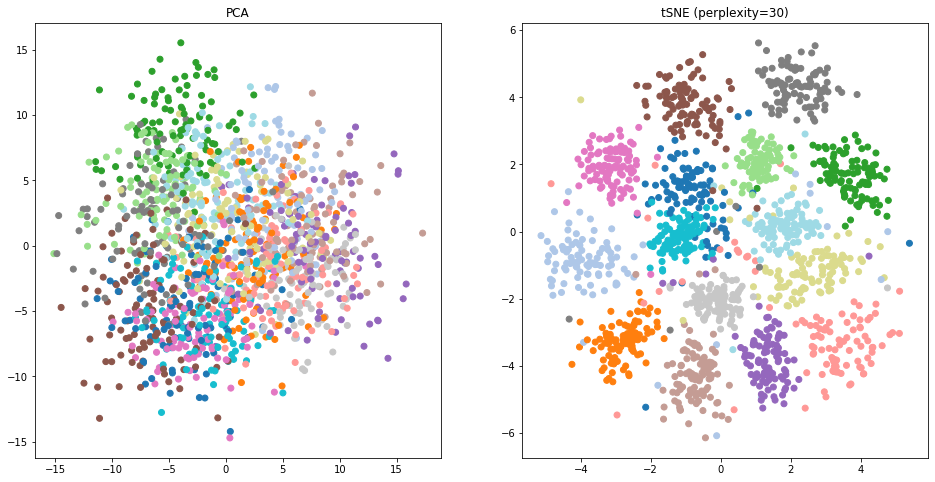

In [1288]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.scatter(*pca_blobs.T, c=y, cmap='tab20')
plt.title('PCA')
plt.subplot(1,2,2)
plt.scatter(*tsne_blobs.T, c=y, cmap='tab20')
plt.title(F'tSNE (perplexity={30})');

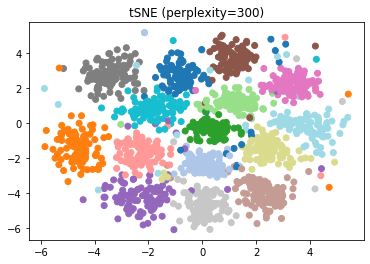

In [1291]:
tsne_blobs = TSNE(random_state=42, perplexity=300).fit_transform(X)
plt.scatter(*tsne_blobs.T, c=y, cmap='tab20')
plt.title(F'tSNE (perplexity={300})');

Видим, что tSNE достаточно удачно выделил кластеры из перемешанных данных. Но что, если кластеров нет?

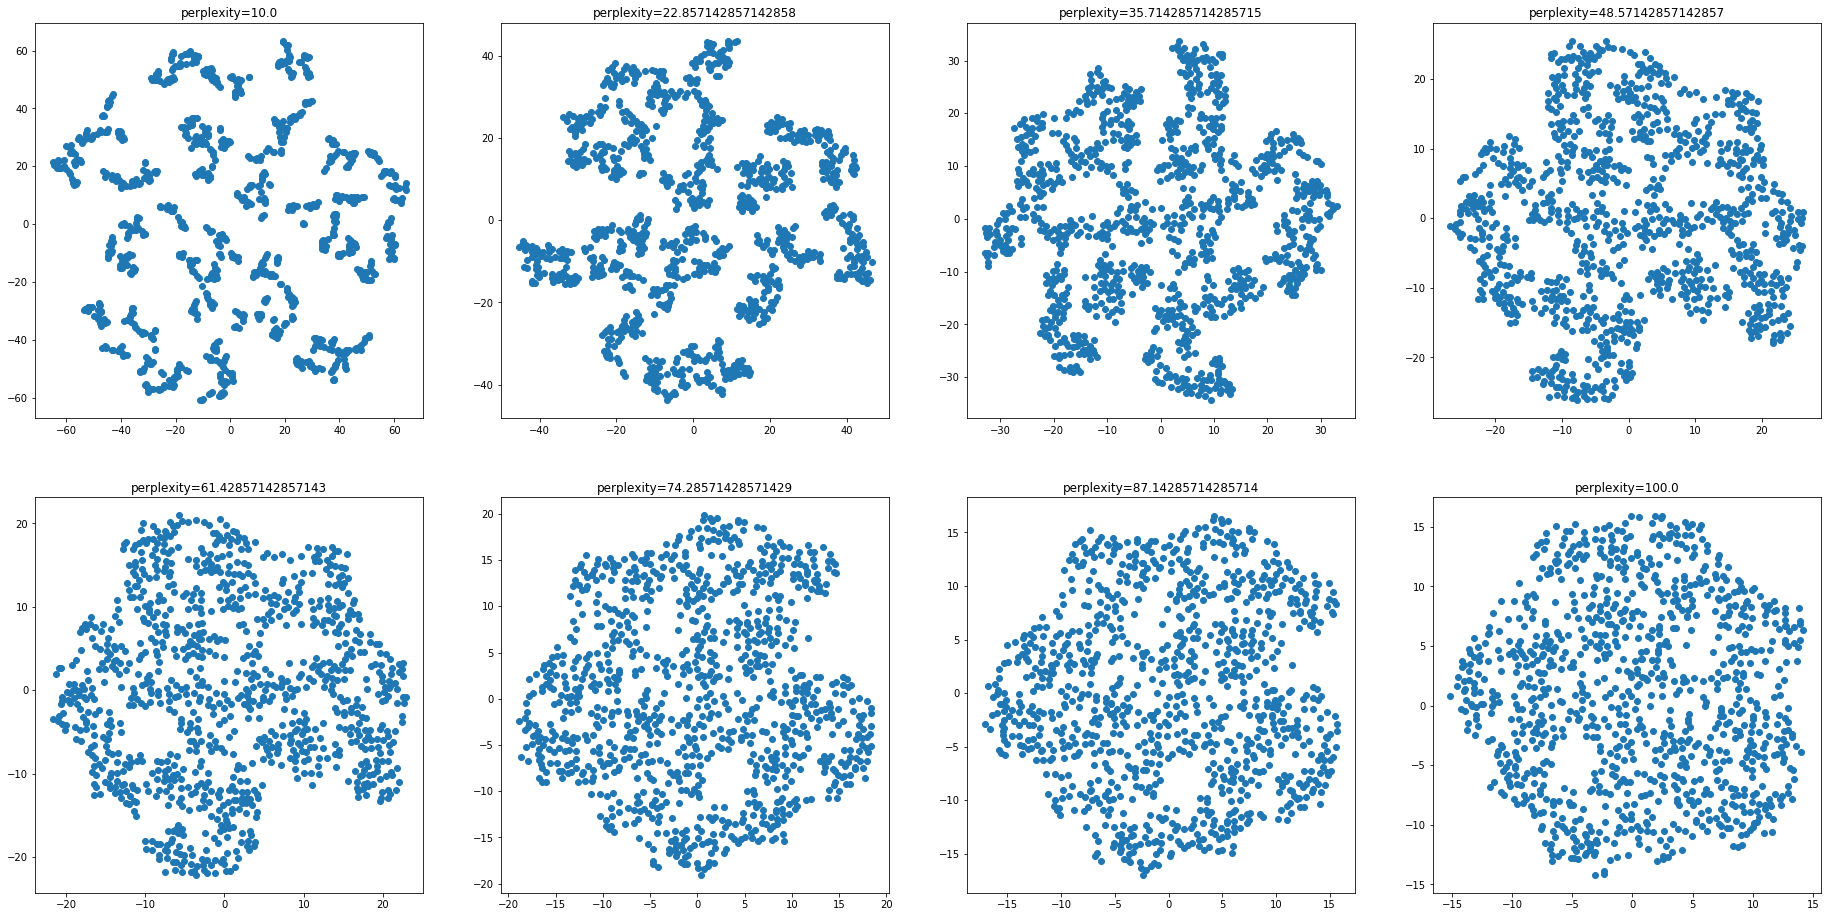

In [1294]:
X = np.random.randn(1000,2)
n_subplots=8
fig, axs = plt.subplots(2, n_subplots//2, figsize=(8*n_subplots//2, 16))
perplexity = np.linspace(10,100,n_subplots)
for i in range(n_subplots):
    tsne_X = TSNE(
        random_state=42, perplexity=perplexity[i]).fit_transform(
        X
    )
    axs.ravel()[i].scatter(*tsne_X.T)
    axs.ravel()[i].set_title(F'perplexity={perplexity[i]}')

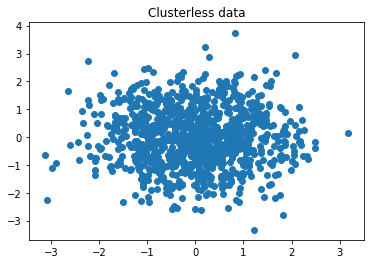

In [1295]:
plt.scatter(*X.T);
plt.title('Clusterless data');

На низких значениях perplexity мы видим на графиках самообразовавшуюся структуру. На результаты tSNE стоит смотреть осторожно, и всегда полезно сравнить графики для разных значений perplexity. По [ссылке](https://distill.pub/2016/misread-tsne/) можно посмотреть очень интересную статью с качественными визуализациями.

## Кластеризация

Что, если мы получили красивый график, на котором отчетливо выделяются сгустки точек, и хотим пометить сгустки? Для этого нам понадобятся алгоритмы кластеризации.